In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
%matplotlib inline
import os

In [2]:
#####pick top three ranked protospacer sequences
def pick_top3(rank):
    if((rank==1)or(rank==2)or(rank==3)):
        return(1)
    else:
        return(0)
######read in files
sel_genes = pd.read_csv("selected_genes.txt",sep='\t',header=None)
sg_table = pd.read_csv("elife-19760-supp3-v2.1.csv",sep=',')
sg_table = sg_table.drop([0,1,2,3,4,5,6,7,8],axis=0)
sg_table = sg_table[['sgID','gene','transcript','protospacer sequence','selection rank','predicted score','empirical score']]
#####merge by searching selected genes
sg_select = pd.merge(sel_genes,sg_table,left_on=0,right_on='gene')
#####select top 3 genes
sg_select['in_top'] = sg_select.apply(lambda row: pick_top3(row['selection rank']),axis=1)
sg_select = sg_select[sg_select['in_top']==1]
#####for those with duplicates, take only P1 (primary predicted TSS)
sg_select = sg_select[sg_select['transcript']!='P2']
print("number of sgRNAs:")
print(sg_select.shape[0])
#####print number of genes found with guides
tmp = sg_select[0]
tmp = tmp.drop_duplicates()
print("number of genes:")
print(tmp.shape[0])
####save
sg_select = sg_select.drop([0],axis=1)
sg_select.to_csv('top3.csv',sep=',',header=None,index=None)

/home/johnny/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


number of sgRNAs:
408
number of genes:
130


In [3]:
####replace algorithm score by empirical score if empirical score exists
def replace_vals(val_1,val_2):
    if pd.isnull(val_1):
        return(val_2)
    else: 
        return(val_1)
    
######import top3 sgRNAs for each gene
top3 = pd.read_csv("top3.csv",sep=',',header=None)
######apply replace_vals fn
top3[9] = top3.apply(lambda row: replace_vals(row[6],row[5]),axis=1)
######col 9 is the final concatenated scores
top3.head()

,0,1,2,3,4,5,6,7,9
0,KCTD17_-_37448001.23-P1P2,KCTD17,P1P2,GTCGGACCGGGTGAGGCCCC,1,NaN,1.538564,1,1.538564
1,KCTD17_+_37448037.23-P1P2,KCTD17,P1P2,GGGCCCGACAGCCCCGCGTC,2,NaN,1.253110,1,1.253110
2,KCTD17_-_37447809.23-P1P2,KCTD17,P1P2,GCCGCGGCCGGCGATGAGGA,3,0.856305,NaN,1,0.856305
3,FN1_+_216300745.23-P1P2,FN1,P1P2,GGGGGAGGAGAGGGAACCCC,1,0.896499,NaN,1,0.896499
4,FN1_+_216300728.23-P1P2,FN1,P1P2,GCCAGGCGCGAGCGGGAAGA,2,0.847224,NaN,1,0.847224


percentile cutoff
10
percentile value
0.6975616379


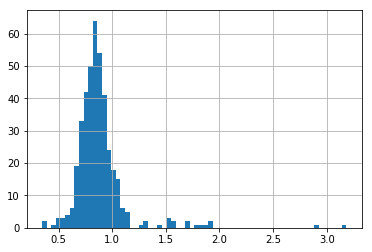

In [4]:
####graph distribution of scores
top3[9].hist(bins='auto')
####determine percentile value
pct_cutoff = 10
pct = np.percentile(top3[9],pct_cutoff)
##print
print("percentile cutoff")
print(pct_cutoff)
print("percentile value")
print(pct)

In [5]:
#####cutoff top3 table by percentile value
##print
print("guides before pct cutoff")
print(top3.shape[0])
#######cutoff
top3 = top3[top3[9]> pct]
##print
print("guides after pct cutoff")
print(top3.shape[0])
#####determine number of genes remaining with 3 guides per gene
tmp_genes = top3[1]
tmp_genes.to_csv('tmp_genes',sep='\t',header=None,index=None)
cmd = 'sort tmp_genes | uniq -c > tmp_uniq.out'
os.system(cmd)
tmp_uniq = pd.read_csv('tmp_uniq.out',header=None,sep=' ')
tmp_uniq = tmp_uniq[[6,7]]
print("num of genes remaining")
tmp_remain = tmp_uniq[tmp_uniq[6]>2].shape
print(tmp_remain[0])
######remove tmp files
os.system("rm tmp*")
######keep only those with 3 guides per gene
tmp_uniq = pd.DataFrame(tmp_uniq[tmp_uniq[6]>2][7])
tmp_uniq = pd.merge(tmp_uniq,top3,left_on=7,right_on=1)
print('num of guides left')
print(tmp_uniq.shape[0])
###format
tmp_uniq = tmp_uniq.drop(['7_x','7_y',5,6,7],axis=1)

guides before pct cutoff
408
guides after pct cutoff
367
num of genes remaining
108
num of guides left
335


In [6]:
######generate cloning oligos from protospacer sequences
seq_5prime = 'ATTTTGCCCCTGGTTCTTCCACCTTGTTG'
seq_3prime = 'gtttaagaGCTAAGCTGCCAGTTCATTTCTTAGGG'
tmp_uniq[10] = tmp_uniq.apply(lambda row: seq_5prime+row[3]+seq_3prime,axis=1)
######save file
tmp_uniq.to_csv('top3_final.csv',sep=',',header=None)
tmp_uniq.head()

,0,1,2,3,4,9,10
0,CEP89_+_33462702.23-P1P2,CEP89,P1P2,GCGCCGCGCGTGGGGCTCTG,1,1.885621,ATTTTGCCCCTGGTTCTTCCACCTTGTTGGCGCCGCGCGTGGGGCT...
1,CEP89_+_33462640.23-P1P2,CEP89,P1P2,GTTGGCCTGAGATCCAGTCA,2,0.756717,ATTTTGCCCCTGGTTCTTCCACCTTGTTGGTTGGCCTGAGATCCAG...
2,CEP89_-_33462806.23-P1P2,CEP89,P1P2,GCAGCGCGAGGAGAATGGAC,3,0.855756,ATTTTGCCCCTGGTTCTTCCACCTTGTTGGCAGCGCGAGGAGAATG...
3,CHFR_+_133464165.23-P1P2,CHFR,P1P2,GTGTCTCTTGACAGCGGCGG,1,0.845337,ATTTTGCCCCTGGTTCTTCCACCTTGTTGGTGTCTCTTGACAGCGG...
4,CHFR_-_133463971.23-P1P2,CHFR,P1P2,GTGGAGACTCCCGACCCCAG,2,0.819787,ATTTTGCCCCTGGTTCTTCCACCTTGTTGGTGGAGACTCCCGACCC...
